In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import oggm
import os

ModuleNotFoundError: No module named 'oggm'

### Importing glacier geometry data

We can use OGGM to import the glacier geometry for Findelen. This produces a ``GeoDataFrame`` object from `geopandas`. 

2023-05-05 11:29:26: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-05 11:29:26: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-05 11:29:26: oggm.cfg: Multiprocessing: using all available processors (N=8)


<AxesSubplot:>

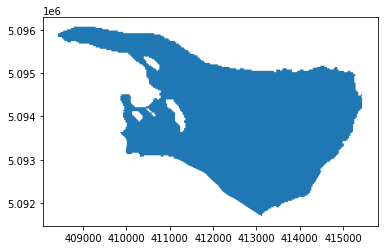

In [ ]:
from oggm import cfg, workflow, graphics, tasks, utils
import geopandas as gpd

cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-shop', reset=True)

glacier = utils.get_rgi_glacier_entities(['RGI60-11.02773'], version='62').to_crs(32632)
glacier.geometry.plot()

### Accessing velocity data from ITS_LIVE

I couldn't figure out how to use OGGM to directly import velocity data; we have to go on [ITS_LIVE](https://nsidc.org/apps/itslive/) and use the app to manually download the velocity image pairs.

This gives us a text file containing urls to download the image pairs. Using a little programming, we can download them all and put them in a tidy folder.

In [ ]:
# we store the urls in a list and create a savepath
txt_path = r'C:\Users\alexi\Desktop\2scool4cool\a2022\image_matching\data\pairs_urls.text'

with open(txt_path, 'r') as file:
    urls = [line.rstrip() for line in file]
    
savepath = r'C:\Users\alexi\Desktop\2scool4cool\a2022\image_matching\data\Findelen'
try:
    os.makedirs(savepath)
except OSError:
    pass


In [ ]:
# here we download the files!!
import requests

for i, url in enumerate(urls):
    
    file_name = url.split('/')[-1]
    print(f'\rDownloading {i+1} out of {len(urls)}: {file_name}', end='')
    
    r = requests.get(url, stream=True)
    
    try:
        
        with open(os.path.join(savepath, file_name), 'wb') as f:
            for data in r:
                f.write(data)
            
    except PermissionError:
        pass

### Processing the downloaded rasters

We will now open every raster and clip it to the glacier's geometry. We can do so easily using the library ``rioxarray`` built on top of ``xarray``.

In [ ]:
from datetime import datetime
import rioxarray as rxr

# we will store everything in lists, could be arrays but it's simpler and worryless
times = []
velocities = []

for i, file in enumerate(os.listdir(savepath)):
    print(f'\rClipping {i+1} out of {len(urls)}: {file}', end='')

    # we want to extract the time at which the image pairs were taken 
    meta = file.split('_')
    
    if len(meta) == 23:
        
        t1 = datetime.strptime(str(meta[5].split('T')[0]), '%Y%m%d')
        t2 = datetime.strptime(str(meta[16].split('T')[0]), '%Y%m%d')
                
    elif len(meta) == 13:
        t1 = datetime.strptime(str(meta[2]), '%Y%m%d')
        t2 = datetime.strptime(str(meta[8]), '%Y%m%d')
    
    # we compute the middle point between the two image pairs
    t = t1 + (t2 - t1)/2
    
    print(f', time is {t}', end='')
    
    
    try:
        # we open the raster
        ras = rxr.open_rasterio(os.path.join(savepath, file))
        # give it a proper spatial reference (idk if necessary)
        ras.rio.set_spatial_dims('y', 'x', inplace=True)
        ras.rio.write_crs('epsg:32632', inplace=True)
    
        # clip it with the glacier geometry
        ras = ras.rio.clip(glacier.geometry)
        
    except Exception:
        continue

    # we write those to the lists
    times.append(t)
    velocities.append(ras)
    

In [ ]:
# we see that the rasters have weird values outside the glacier...
maskval = ras.v.min()
ras.v.plot()

In [ ]:
veloc = [v.v for v in velocities]

In [ ]:
# we need to process this
import xarray as xr


stacked_velocities = xr.concat(veloc, dim='t')
stacked_velocities['t'] = times
stacked_velocities = stacked_velocities.sortby('t')

mask = stacked_velocities <= -1000
stacked_velocities = xr.where(mask, np.nan, stacked_velocities)

stacked_velocities.mean('t').plot()

stacked_velocities.to_netcdf('veloc.nc')

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0, mapping = 0'}, xlabel='x', ylabel='y'>

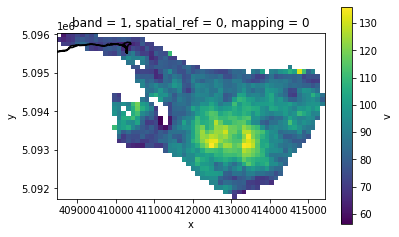

In [ ]:
# I have been on this glacier once... let's superimpose our data
import xarray as xr
stacked_velocities = xr.load_dataset('veloc.nc')['v']
lines_path = r'C:\Users\alexi\Desktop\2scool4cool\a2022\image_matching\data\CRAG_Easter_field_work_.gpx'
lines = gpd.read_file(lines_path, layer='tracks').to_crs('epsg:32632')

stacked_velocities.mean('t').plot()
lines.plot(ax=plt.gca(), color='k')

### Looks like we really were on this glacier! 

Not so far up east however. By extracting point data, we can look at a convenient time series.

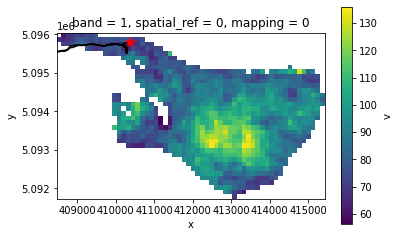

In [ ]:
# The furthermost north-east point will do nicely.
xy = np.array(lines.geometry[0].geoms[0].xy)

ii = np.linalg.norm(xy, axis=0).argmax()
point = xy[:, ii]

stacked_velocities.mean('t').plot()
lines.plot(ax=plt.gca(), color='k')
plt.scatter(*point, c='red', marker='*', zorder=10, s=100)

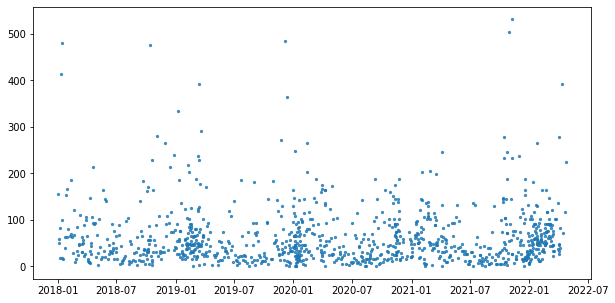

In [ ]:
# extracting the data close to the point
ts = stacked_velocities.sel(x=point[0], y=point[1], method='nearest')
vel = ts.values
t = ts.t.values

plt.figure(figsize=(10, 5))
plt.scatter(t, vel, c='tab:blue', s=5, alpha=0.8)

Text(0, 0.5, 'V (ma$^{-1}$)')

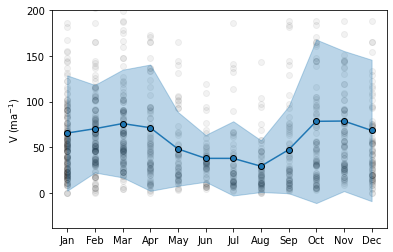

In [ ]:
ts = ts.dropna(dim='t')
monthly = ts.groupby('t.month')
for i, month in monthly:
    plt.scatter(i + month*0, month, alpha=0.05, c='k')

x = np.arange(1, 13)
plt.plot(x, monthly.mean(), c='tab:blue', marker='.', mec='k', ms=12)
plt.fill_between(x, 
                 (monthly.mean() - monthly.std()).values.flatten(),
                 (monthly.mean() + monthly.std()).values.flatten(), ec='tab:blue', fc='tab:blue', alpha=0.3)
#plt.xlim(1, 12)
plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(None, 200)
plt.ylabel('V (ma$^{-1}$)')